In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [3]:
df = pd.read_csv("complaints-2025-09-21_04_41.csv")
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,08/28/25,Credit reporting or other personal consumer re...,Credit reporting,Problem with a company's investigation into an...,Investigation took more than 30 days,NaN,None,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AR,72901,None,None,Web,08/28/25,In progress,Yes,NaN,15576155
1,09/01/25,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,None,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",TX,76040,None,None,Web,09/01/25,In progress,Yes,NaN,15636031
2,08/27/25,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,None,Experian Information Solutions Inc.,FL,33319,None,None,Web,08/27/25,In progress,Yes,NaN,15549463
3,07/11/25,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,I did not initiate these inquiries and believe...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",TX,761XX,None,Consent provided,Web,07/11/25,Closed with non-monetary relief,Yes,NaN,14595898
4,07/24/25,Mortgage,FHA mortgage,Struggling to pay mortgage,Trying to communicate with the company to fix ...,NaN,None,"AmeriHome Mortgage Company, LLC",FL,34983,None,None,Web,08/01/25,In progress,Yes,NaN,14869942


In [4]:
df.shape

(1511771, 18)

In [6]:
df.columns.tolist()

['Date received',
 'Product',
 'Sub-product',
 'Issue',
 'Sub-issue',
 'Consumer complaint narrative',
 'Company public response',
 'Company',
 'State',
 'ZIP code',
 'Tags',
 'Consumer consent provided?',
 'Submitted via',
 'Date sent to company',
 'Company response to consumer',
 'Timely response?',
 'Consumer disputed?',
 'Complaint ID']

In [7]:
pd.set_option('display.max_colwidth', None)
print("Unique product names:")
print(df['Product'].unique())
pd.reset_option('display.max_colwidth')

narratives = df['Consumer complaint narrative'].dropna()
if len(narratives) > 0:
    print("\nFirst complaint example:")
    print(narratives.iloc[0])
else:
    print("\nNo complaints found!")

print("\nMissing in Product:", df['Product'].isnull().sum())
print("Missing in Complaint:", df['Consumer complaint narrative'].isnull().sum())
print("Total rows:", len(df))

Unique product names:
['Credit reporting or other personal consumer reports' 'Mortgage'
 'Debt collection' 'Credit card' 'Checking or savings account'
 'Money transfer, virtual currency, or money service'
 'Payday loan, title loan, personal loan, or advance loan' 'Student loan'
 'Vehicle loan or lease' 'Debt or credit management' 'Prepaid card']

First complaint example:
I did not initiate these inquiries and believe they may involve unauthorized activity. Kindly investigate this issue and take corrective action promptly. The documentation is enclosed for your reference.

Missing in Product: 0
Missing in Complaint: 1381125
Total rows: 1511771


In [8]:
# Map products to categories
category_map = {
    'Credit reporting or other personal consumer reports': 0,
    'Debt collection': 1,
    'Payday loan, title loan, personal loan, or advance loan': 2,
    'Student loan': 2,
    'Vehicle loan or lease': 2,
    'Mortgage': 3
}

df['category'] = df['Product'].map(category_map)

# Check how many records in each category
print("Category counts (with NaN included):")
print(df['category'].value_counts(dropna=False))

Category counts (with NaN included):
0.0    1374168
1.0      71639
NaN      49052
2.0      11592
3.0       5320
Name: category, dtype: int64


In [9]:
# Keeping only rows with mapped categories
df = df.dropna(subset=['category'])

# Drop rows without complaint text
before = len(df)
df = df.dropna(subset=['Consumer complaint narrative'])
after = len(df)

print("Dropped", before - after, "rows with empty complaints")
print("Final shape:", df.shape)

# Class distribution
print("\nClass counts:")
print(df['category'].value_counts())

print("\nClass %:")
print((df['category'].value_counts(normalize=True) * 100).round(2))

Dropped 1345129 rows with empty complaints
Final shape: (117590, 19)

Class counts:
0.0    102015
1.0     10633
2.0      3117
3.0      1825
Name: category, dtype: int64

Class %:
0.0    86.75
1.0     9.04
2.0     2.65
3.0     1.55
Name: category, dtype: float64


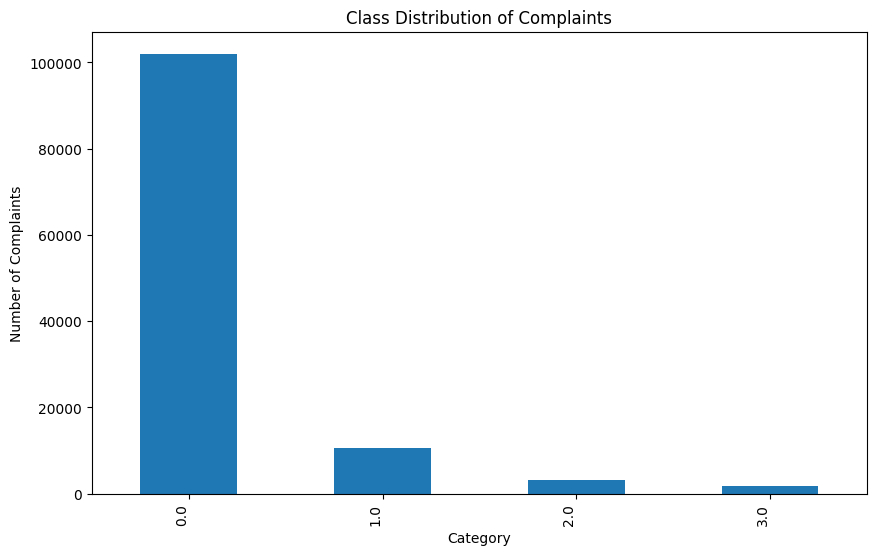

In [11]:
import matplotlib.pyplot as plt

# Class counts
class_counts = df['category'].value_counts()

# Plot
plt.figure(figsize=(10,6))
class_counts.plot(kind='bar')

plt.title("Class Distribution of Complaints")
plt.xlabel("Category")
plt.ylabel("Number of Complaints")
plt.xticks(ha="right")
plt.show()


In [13]:
# Clean text function
def clean_text(text):
    if not isinstance(text, str):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove non-alphabetic characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize
    words = text.split()
    
    # Remove stopwords
    words = [w for w in words if w not in stop_words]
    
    # Lemmatize words
    words = [lemmatizer.lemmatize(w) for w in words]
    
    # Join back into a single string
    return ' '.join(words)


In [18]:
print("Cleaning text data")
df['cleaned_text'] = df['Consumer complaint narrative'].apply(clean_text)

print("Original:", df['Consumer complaint narrative'].iloc[0][:100] + "...")
print("Cleaned: ", df['cleaned_text'].iloc[0][:100] + "...")


Cleaning text data
Original: I did not initiate these inquiries and believe they may involve unauthorized activity. Kindly invest...
Cleaned:  initiate inquiry believe may involve unauthorized activity kindly investigate issue take corrective ...


In [19]:
# features and target
X = df['cleaned_text']
y = df['category']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [20]:
# Convert text to numerical features
print("Converting text to numerical features")
vectorizer = TfidfVectorizer(max_features=5000)  # stop_words already removed
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


Converting text to numerical features


In [21]:
# Balance training data using RandomOverSampler (works on sparse data)
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train_tfidf, y_train)

print(f"Training features shape: {X_train_res.shape}")
print(f"Testing features shape: {X_test_tfidf.shape}")

Training features shape: (326448, 5000)
Testing features shape: (23518, 5000)


In [24]:
# Define models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

models = {
    'Logistic Regression': LogisticRegression(random_state=42, class_weight='balanced', max_iter=500, solver='saga'),
    'Naive Bayes': MultinomialNB(),
}

In [26]:
from sklearn.metrics import accuracy_score, classification_report, f1_score

for name, model in models.items():
    print(f"\nTraining {name}:")
    model.fit(X_train_res, y_train_res)
    
    y_pred = model.predict(X_test_tfidf)
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    
    print(f"{name} Accuracy: {acc:.4f}")
    print(f"{name} Macro F1-score: {f1:.4f}")
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))
    print("-"*60)



Training Logistic Regression:
Logistic Regression Accuracy: 0.9122
Logistic Regression Macro F1-score: 0.7732

Logistic Regression Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.92      0.95     20403
         1.0       0.60      0.86      0.71      2127
         2.0       0.49      0.82      0.61       623
         3.0       0.74      0.90      0.82       365

    accuracy                           0.91     23518
   macro avg       0.71      0.88      0.77     23518
weighted avg       0.94      0.91      0.92     23518

------------------------------------------------------------

Training Naive Bayes:
Naive Bayes Accuracy: 0.8661
Naive Bayes Macro F1-score: 0.6764

Naive Bayes Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.88      0.93     20403
         1.0       0.53      0.75      0.62      2127
         2.0       0.31      0.87      0.46       623
         

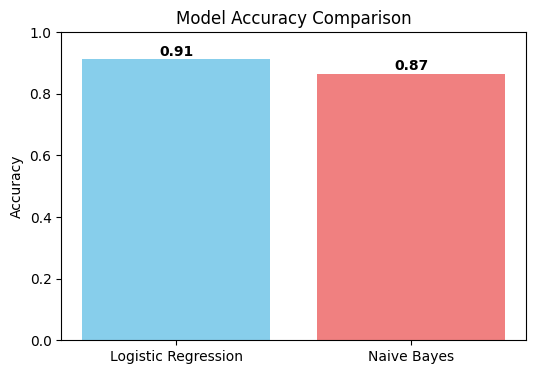

In [29]:
import matplotlib.pyplot as plt

# Model names and their accuracy
model_names = ['Logistic Regression', 'Naive Bayes']
accuracy_scores = [0.9122, 0.8661]

plt.figure(figsize=(6,4))
bars = plt.bar(model_names, accuracy_scores, color=['skyblue', 'lightcoral'])

# Add accuracy values on top of bars
for bar, acc in zip(bars, accuracy_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f"{acc:.2f}", 
             ha='center', fontweight='bold')

plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.show()


In [30]:
# Assign best model
best_model = models['Logistic Regression']

# New complaints
new_complaints = [
    "I am being called by a debt collector every day",
    "My credit report has wrong information",
    "I need help with my student loan payment",
    "I am having trouble with my mortgage company"
]

# Clean text
cleaned_new = [clean_text(text) for text in new_complaints]

# Convert to TF-IDF
X_new_tfidf = vectorizer.transform(cleaned_new)

# Predict categories
predictions = best_model.predict(X_new_tfidf)

# Map numeric categories to names
category_map = {0:'Credit Reporting', 1:'Debt Collection', 2:'Consumer Loan', 3:'Mortgage'}
pred_category_names = [category_map[int(p)] for p in predictions]

# Display results
import pandas as pd
df_preds = pd.DataFrame({
    'Complaint': new_complaints,
    'Predicted Category': pred_category_names
})
print(df_preds)


                                         Complaint Predicted Category
0  I am being called by a debt collector every day    Debt Collection
1           My credit report has wrong information   Credit Reporting
2         I need help with my student loan payment      Consumer Loan
3     I am having trouble with my mortgage company           Mortgage
